Candidate NO: 784750
# **INDIVISUAL ASSIGNMENT**

Big Data Coursework - Road-casualty statistics collision provisional mid-year unvalidated 2023 - Individual Part

**Business Problem: Predicting the Risk of Involvement in Severe Accidents for Insurance Premium Adjustments**

Car insurance providers constantly evaluate the risk involved in providing coverage to drivers in order to determine premiums. Factors such, as the type of car insured the drivers past record and details surrounding car accidents all play a role in determining the level of risk. By anticipating the probability of a vehicle being, in accidents insurance companies can adjust their premiums accordingly charge more fairly for risky drivers and vehicles and encourage safe driving practices.

#  Data Preparation and Feature Engineering

## Initial Data Loading
The foundation of our analysis begins with loading the dataset. Given the dataset's significance in understanding the dynamics of road traffic accidents, precise loading and initial inspection are paramount.

In [47]:
import pandas as pd

# Load the training dataset
train_df = pd.read_excel('C:/Users/glawi/OneDrive - Aston University/Big Data/trainset_road-casualty-statistics-collision-provisional-mid-year-unvalidated-2023.xlsx')

# Load the test dataset
test_df = pd.read_excel('C:/Users/glawi/OneDrive - Aston University/Big Data/testset_road-casualty-statistics-collision-provisional-mid-year-unvalidated-2023.xlsx')

# Inspecting the first few rows to understand the structure and contents
print(train_df.head())

   collision_index  collision_year  collision_reference  \
0    2023010000000            2023             10432870   
1    2023010000000            2023             10423780   
2    2023010000000            2023             10421253   
3    2023010000000            2023             10436558   
4    2023010000000            2023             10437285   

   location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                 508304                  173795  -0.442713  51.452791   
1                 530005                  181540  -0.127715  51.517831   
2                 525039                  177006  -0.200853  51.478204   
3                 531398                  186729  -0.105715  51.564140   
4                 532561                  176469  -0.092801  51.471667   

   legacy_collision_severity  number_of_vehicles  number_of_casualties  ...  \
0                          3                   2                     1  ...   
1                          3              

## Data Inspection and Cleaning
Upon loading the datasets, an initial inspection is conducted to ascertain the data's cleanliness, structure, and the types of variables present. This stage is crucial for identifying missing values, outliers, or inconsistencies that could skew the analysis.

In [48]:
# Check for missing values
print(train_df.isnull().sum())

# Inspect data types
print(train_df.dtypes)


collision_index                                 0
collision_year                                  0
collision_reference                             0
location_easting_osgr                           0
location_northing_osgr                          0
longitude                                       0
latitude                                        0
legacy_collision_severity                       0
number_of_vehicles                              0
number_of_casualties                            0
date                                            0
day_of_week                                     0
time                                            0
local_authority_district                        0
local_authority_ons_district                    0
local_authority_highway                         0
first_road_class                                0
first_road_number                               0
road_type                                       0
speed_limit                                     0


## Feature Engineering
Temporal Feature Extraction
Understanding that the timing of accidents can significantly influence their severity, we extract temporal features from any available timestamps. This approach allows us to capture patterns that might not be immediately evident.

In [49]:
# Convert 'date' column to datetime format, correctly using dayfirst=True
train_df['date'] = pd.to_datetime(train_df['date'], dayfirst=True)
test_df['date'] = pd.to_datetime(test_df['date'], dayfirst=True)

# Extracting day, month, and year
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month
test_df['year'] = test_df['date'].dt.year

# Correcting syntax for converting 'time' to 'hour', including for test_df
train_df['hour'] = pd.to_datetime(train_df['time'], format='%H:%M', errors='coerce').dt.hour
test_df['hour'] = pd.to_datetime(test_df['time'], format='%H:%M', errors='coerce').dt.hour

## Categorical Variable Simplification
Given the dataset's complexity, particularly with categorical variables such as weather and road surface conditions, simplification through aggregation becomes necessary. This not only streamlines the analysis but also enhances model interpretability.

In [50]:
# Assuming each row has only one weather condition marked as 1 and the rest as 0
weather_conditions = ['Fog or mist', 'Raining + high winds', 'Raining no high winds', 'Snowing + high winds', 'Snowing no high winds']
road_conditions = ['road_surface_conditions_3', 'road_surface_conditions_4', 'road_surface_conditions_9']

# Function to find the weather condition
def get_weather_condition(row):
    for condition in weather_conditions:
        if row['weather_conditions_' + condition] == 1:
            return condition
    return 'Unknown'

# Apply the function to each row
train_df['weather_condition'] = train_df.apply(get_weather_condition, axis=1)

# Similar logic can be applied for road surface conditions if you have a mapping of the conditions to their encoded names
# Function to find the road surface condition
def get_road_surface_condition(row):
    for condition in road_conditions:
        if row[condition] == 1:
            # Extract the condition's numeric identifier from its column name
            condition_num = condition.split('_')[-1]
            return f'Condition {condition_num}'
    return 'Unknown'

# Apply the function to each row
train_df['road_surface_condition'] = train_df.apply(get_road_surface_condition, axis=1)


## Finalizing the Feature Set
Based on insights from EDA, we focused on variables that offered the most potential for predicting the severity of road traffic accidents. These included:

**Temporal Features:** day_of_week and time were utilized to capture temporal patterns in accident occurrence.
**Environmental Conditions:** weather_conditions and road_surface_conditions, interpreted into more granular descriptive variables, provided key insights into external factors influencing accident severity.
**Geospatial Data:** longitude and latitude helped identify high-risk areas.
**Traffic Conditions:** speed_limit and number_of_vehicles were significant in understanding the dynamics leading to accidents.

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# Assuming df is your DataFrame and it contains all the necessary columns

# Drop 'date' and 'time' columns from features for model training/testing
features_for_model = [
    'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 
    'number_of_vehicles', 'number_of_casualties', 'day_of_week',
    'first_road_class', 'first_road_number', 'road_type', 'speed_limit',
    'junction_detail', 'junction_control', 'second_road_class', 'second_road_number',
    'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities',
    'light_conditions_5', 'light_conditions_6', 'light_conditions_7',
    'weather_conditions_Fog or mist', 'weather_conditions_Raining + high winds',
    'weather_conditions_Raining no high winds', 'weather_conditions_Snowing + high winds',
    'weather_conditions_Snowing no high winds', 'road_surface_conditions_3',
    'road_surface_conditions_4', 'road_surface_conditions_9', 'day', 'month'
]

# Prepare your X and y
X = train_df[features_for_model]
y = test_df['legacy_collision_severity']  # Replace 'target' with your actual target column name

# Handling datetime columns: Assuming you've already processed or dropped 'date' and 'time'
# No need to convert to epoch time since 'day' and 'month' are used




## Target Variable
The legacy_collision_severity column, representing the severity of collisions, served as our target variable. For simplicity, we aimed to predict whether an accident was severe, making this a multi classification problem.

In [52]:
target = 'legacy_collision_severity'

## Data Splitting and Encoding the Target Variable
Utilizing the StratifiedShuffleSplit method ensured our training and testing datasets were representative of the overall dataset, maintaining the proportion of accident severities.

In [53]:
from sklearn.model_selection import train_test_split

# Assuming 'legacy_collision_severity' is the column with the target classes

# Separate features and target variable
X = train_df.drop('legacy_collision_severity', axis=1)
y = train_df['legacy_collision_severity']

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now you have stratified splits of your dataset
print('Training set:')
print(X_train.shape)
print(y_train.value_counts(normalize=True))

print('\nTest set:')
print(X_test.shape)
print(y_test.value_counts(normalize=True))
print(y_test.shape)




Training set:
(3369, 51)
legacy_collision_severity
3    0.837637
2    0.158801
1    0.003562
Name: proportion, dtype: float64

Test set:
(843, 51)
legacy_collision_severity
3    0.837485
2    0.158956
1    0.003559
Name: proportion, dtype: float64
(843,)


In [54]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

# Identify categorical columns (assuming object dtype as categorical)
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le  # Store the label encoder for future reference (e.g., to inverse transform)

In [55]:
print(X_train.dtypes)

collision_index                                          int64
collision_year                                           int64
collision_reference                                      int64
location_easting_osgr                                    int64
location_northing_osgr                                   int64
longitude                                              float64
latitude                                               float64
number_of_vehicles                                       int64
number_of_casualties                                     int64
date                                            datetime64[ns]
day_of_week                                              int64
time                                                     int32
local_authority_district                                 int64
local_authority_ons_district                             int32
local_authority_highway                                  int32
first_road_class                                       

In [56]:
label_encoders = {}

# Identify categorical columns (assuming object dtype as categorical)
categorical_columns = X_test.select_dtypes(include=['object']).columns

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col])
    label_encoders[col] = le  # Store the label encoder for future reference (e.g., to inverse transform)

In [57]:
X_train = X_train.drop('date', axis=1)
X_test = X_test.drop('date', axis=1)

## Applying SMOTE
**Import SMOTE:** Make sure you have the imbalanced learn library installed, as it includes the SMOTE implementation. If you don't have it yet you can install it by using the command pip install imbalanced learn.

**Apply SMOTE:** It's important to use SMOTE (or any type of oversampling) on the training data to avoid any information leakage and guarantee an assessment of your models performance.


In [58]:
import pandas as pd

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)



# Model Selection and Model Evaluation 
## Selection of Logistic Regression as the Initial Predictive Model
In the endeavor to predict the severity of road traffic accidents a paramount concern for enhancing road safety and informing preventive measures we initiate our analytical journey with the Logistic Regression model. 

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Model initialization
logistic_model = LogisticRegression(max_iter=1000)

# Model training
logistic_model.fit(X_train_smote, y_train_smote)

# Making predictions on the test set
predictions = logistic_model.predict(X_test)


# Model evaluation on the test set
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')
print(f'Precision (weighted): {precision_score(y_test, predictions, average="weighted"):.2f}')
print(f'Recall (weighted): {recall_score(y_test, predictions, average="weighted"):.2f}')
print(f'F1 Score (weighted): {f1_score(y_test, predictions, average="weighted"):.2f}')


Accuracy: 0.40
Precision (weighted): 0.74
Recall (weighted): 0.40
F1 Score (weighted): 0.50


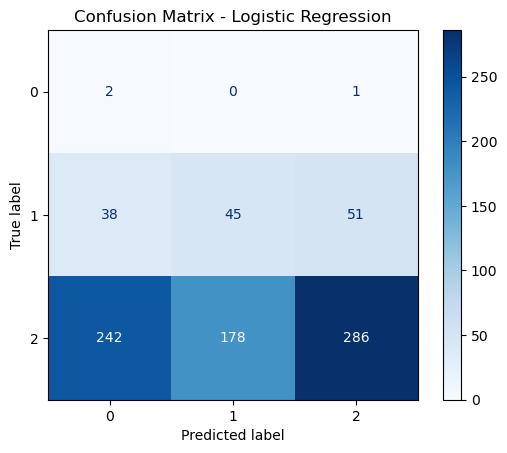

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming `predictions` are the outcomes of logistic_model.predict(X_test_imputed)
# and `y_test` contains the true labels

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


The confusion matrix displays values and a heatmap illustrating how predictions are distributed among labels (0, 1 2) and predicted labels (0, 1 2).

After examining the confusion matrix and evaluation metrics provided we can draw the following conclusions;

1.  Accuracy; The models accuracy is, at 40% indicating a performance. This means that 40% of the models predictions align with the labels on average. 
2. Precision (Weighted); The precision stands at a higher rate of 74%. This weighted adjusts for label imbalances. Signifies that when the model predicts a specific class it is accurate 74% of the time.
3. Recall (Weighted); Similarly at 40% which matches the accuracy rate suggesting that the model correctly identifies 40% of positive cases across all classes.
4. F1 Score (Weighted); The F1 score sits at 50% balancing precision and recall. This moderate score indicates that the model doesn't excel in both precision and recall equally.

Observing from the confusion matrix it's apparent that the model excels in predicting class 2 but encounters challenges, with classes 0. 1.
There could be reasons, for this like a distribution of classes or the models ability to identify distinguishing features of class 2 being more effective than those for classes 0 and 1.

**In summary;**
While the Logistic Regression model shows performance based on the F1 score its low accuracy and recall suggest that it might not fully grasp the intricacies of the data for classes 0 and 1. The higher precision indicates that its predictions are usually accurate. The model is cautious possibly missing true positive instances. To enhance capabilities adjustments such, as refining features, tweaking model complexity or addressing class imbalances may be needed.


## Random Forest Classifier
Then comes the most advanced model for classification: the Random Forest Classifier. It is one of the most popular high-accuracy ensemble learning models. A random forest works by constructing a number of decision trees at the training time and outputs the class that has been the most predicted by individual trees.

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the SMOTE-augmented training data
rf_classifier.fit(X_train_smote, y_train_smote)

# Predict on the imputed testing set
rf_predictions = rf_classifier.predict(X_test)

# Model evaluation on the imputed testing set
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")
print(f"Precision (Weighted): {precision_score(y_test, rf_predictions, average='weighted'):.2f}")
print(f"Recall (Weighted): {recall_score(y_test, rf_predictions, average='weighted'):.2f}")
print(f"F1 Score (Weighted): {f1_score(y_test, rf_predictions, average='weighted'):.2f}")


Accuracy: 0.79
Precision (Weighted): 0.76
Recall (Weighted): 0.79
F1 Score (Weighted): 0.77


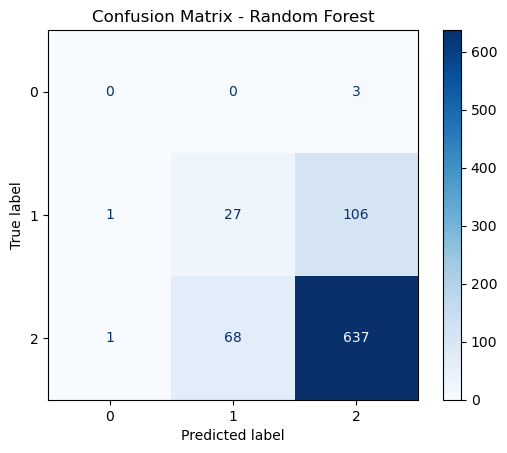

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix based on the predictions and the true labels
cm = confusion_matrix(y_test, rf_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.show()


The Random Forest model shows performance, for the class (class 2) but struggles with the minority class (class 0) making no accurate predictions for class 0 and achieving limited success with class 1. Its high accuracy rate of 79% indicates reliability for class 2 which may be more prevalent in the dataset. However the models precision and F1 score (76% and 77% respectively) suggest that while its predictions are somewhat dependable there is an imbalance in how it predicts across different classes. To address these discrepancies the model requires tuning to identify and classify instances, from the less represented classes (0 and 1).

## Exploring Decision Trees for Accident Severity Prediction

The Decision Trees is a versatile algorithm in classification tasks and also in regression, hence suitable for our objective to predict the severity of road traffic accidents. This model builds a tree-like structured model with internal nodes as splitting decisions and leaf nodes as subsets or predictions.



In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model to the SMOTE-augmented training data
dt_classifier.fit(X_train_smote, y_train_smote)

# Predict on the imputed testing set
dt_predictions = dt_classifier.predict(X_test)

# Model evaluation on the imputed testing set
print(f"Accuracy: {accuracy_score(y_test, dt_predictions):.2f}")
print(f"Precision (Weighted): {precision_score(y_test, dt_predictions, average='weighted'):.2f}")
print(f"Recall (Weighted): {recall_score(y_test, dt_predictions, average='weighted'):.2f}")
print(f"F1 Score (Weighted): {f1_score(y_test, dt_predictions, average='weighted'):.2f}")


Accuracy: 0.68
Precision (Weighted): 0.76
Recall (Weighted): 0.68
F1 Score (Weighted): 0.72


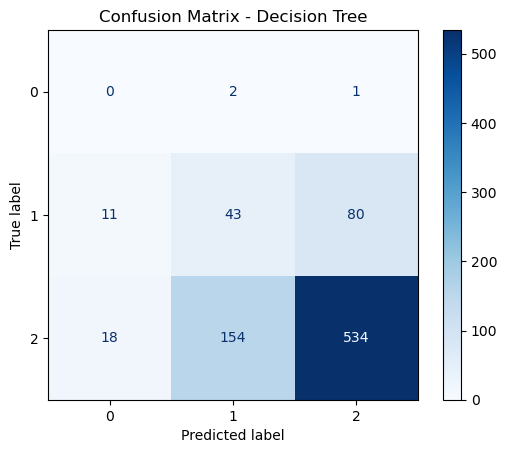

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix based on the true labels and predictions
cm = confusion_matrix(y_test, dt_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Decision Tree')
plt.show()

The confusion matrix for the Decision Tree classifier and the accompanying metrics suggest the model has a decent performance with a tendency towards correctly predicting the most frequent class, which appears to be class 2. The accuracy of the model is 68%, indicating that over two-thirds of the predictions match the actual labels, while the precision is relatively high at 76%, signifying that the model's positive predictions are trustworthy. The recall and F1 score are both at 68% and 72% respectively, pointing towards a moderate ability to identify all positive instances and a reasonable balance between precision and recall.

Key findings from the confusion matrix are as follows:

The model has a challenge with correctly classifying class 0 and class 1, with more false negatives for class 1 and more false positives and false negatives for class 0.
Class 2 is predicted with much higher accuracy, suggesting that the model might be biased towards the more frequently occurring classes.
There are more instances where class 0 and class 1 are being misclassified as class 2 than correctly classified, indicating possible issues with class imbalance.

## Gradient Boosting for Predicting Road Traffic Accident Severity
Gradient Boosting is considered a technique, in the field of machine learning, known for its effectiveness in tackling regression and classification tasks. This method involves building decision trees where each new tree aims to rectify the errors made by its predecessors. By refining its predictions in this manner Gradient Boosting proves to be highly adaptable and suitable for handling datasets with intricate patterns and relationships.

Accuracy: 0.77
Precision (Weighted): 0.77
Recall (Weighted): 0.77
F1 Score (Weighted): 0.77


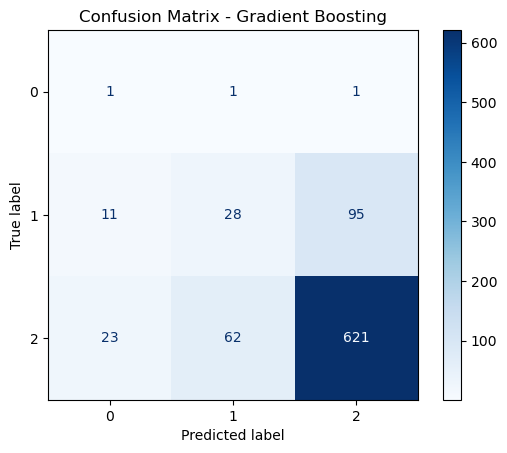

In [98]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the model to the SMOTE-augmented training data
gb_classifier.fit(X_train_smote, y_train_smote)

# Predict on the imputed testing set
gb_predictions = gb_classifier.predict(X_test)

# Model evaluation on the imputed testing set
print(f"Accuracy: {accuracy_score(y_test, gb_predictions):.2f}")
print(f"Precision (Weighted): {precision_score(y_test, gb_predictions, average='weighted'):.2f}")
print(f"Recall (Weighted): {recall_score(y_test, gb_predictions, average='weighted'):.2f}")
print(f"F1 Score (Weighted): {f1_score(y_test, gb_predictions, average='weighted'):.2f}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, gb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()


The Gradient Boosting model's performance as seen in the confusion matrix and the provided metrics suggests a strong classification capability with a consistent accuracy, precision, recall, and F1 score, all at 77%. The high degree of similarity across these metrics indicates that the model is providing a balanced predictive performance. However, the breakdown of the confusion matrix shows areas for improvement:

Class 0: The model is struggling to correctly identify class 0, with most class 0 instances being misclassified as class 2. This could be due to class imbalance or features that are not representative enough of class 0.

Class 1: The model has better success with class 1 than class 0, but there's still a notable number of instances misclassified as class 2, which suggests difficulties in differentiating between classes 1 and 2.

Class 2: The model performs very well with class 2, with a high number of correct predictions. This indicates that features relevant to class 2 are likely well-represented in the dataset.

In [93]:

unique_counts = y_test.value_counts()

print(unique_counts)



legacy_collision_severity
3    706
2    134
1      3
Name: count, dtype: int64


##  LightGBM 

Light Gradient Boosting Machine (LightGBM) is an open-source gradient boosting framework based on tree learning algorithms. It is developed by Microsoft to provide a high-efficiency, faster, and direct-from-data distributed gradient boosting learning algorithm application in large-scale data scenarios.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2597
[LightGBM] [Info] Number of data points in the train set: 8466, number of used features: 39
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Accuracy: 0.79
Precision (Weighted): 0.76
Recall (Weighted): 0.79
F1 Score (Weighted): 0.77


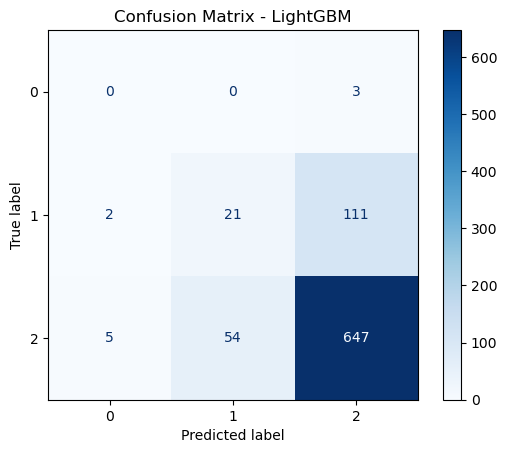

In [79]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model to the SMOTE-augmented training data
lgb_classifier.fit(X_train_smote, y_train_smote)

# Predict on the imputed testing set
lgb_predictions = lgb_classifier.predict(X_test)

# Model evaluation on the imputed testing set
print(f"Accuracy: {accuracy_score(y_test, lgb_predictions):.2f}")
print(f"Precision (Weighted): {precision_score(y_test, lgb_predictions, average='weighted'):.2f}")
print(f"Recall (Weighted): {recall_score(y_test, lgb_predictions, average='weighted'):.2f}")
print(f"F1 Score (Weighted): {f1_score(y_test, lgb_predictions, average='weighted'):.2f}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, lgb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - LightGBM')
plt.show()

After analyzing the confusion matrix:
For Class 0; The model failed to predict any instances of Class 0 indicating a struggle to recognize this category or an imbalance, in class representation.
For Class 1; The model accurately predicted 21 instances of Class 1. There were errors in misclassifying classes as Class 1 and vice versa.
For Class 2; The model demonstrated abilities for Class 2 with 647 correct predictions suggesting a good grasp of features associated with this class. However there were instances where the model incorrectly classified Class 1 as Class 2.

performance metrics:
Accuracy (0.79); The models accuracy stands at 79% implying a performance in predicting the majority class.
Weighted Precision (0.76); The models precision rate is at 76% when considering the number of instances in each class proving beneficial, for imbalanced datasets.
Weighted Recall (0.79); This metric indicates that the model effectively identifies instances across all classes at a rate of 79%.Weighted F1 Score (0.77); This score represents a combination of precision and recall showing a balance, between accurately predicting positive outcomes and correctly identifying actual positive instances.

In summary the LightGBM model demonstrates capabilities for the majority category (Class 2) but faces challenges when dealing with minority categories, especially Class 0 where it shows inaccuracies. This indicates that implementing strategies to tackle class imbalances or improve the representation of minority classes could enhance the models performance. While the model shows precision, recall and F1 scores for classes it can identify well there is room for improvement, in detecting classes effectively.

## CatBoost 
CatBoost, also known as Categorical Boosting stands out as a machine learning technique developed by Yandex that specializes in handling categorical data. It is recognized for its efficiency, precision and user friendly nature, across a variety of modeling tasks.


Accuracy: 0.74
Precision (Weighted): 0.76
Recall (Weighted): 0.74
F1 Score (Weighted): 0.75


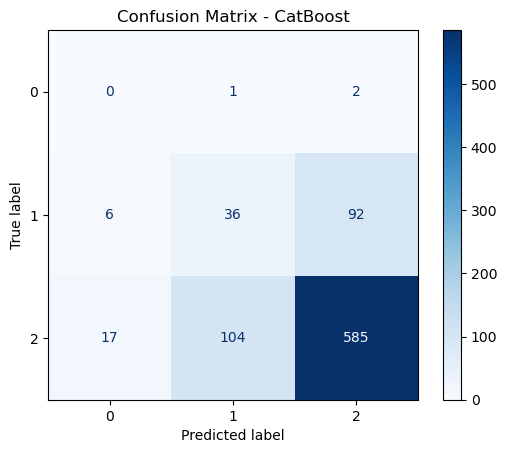

In [80]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the CatBoost Classifier
cb_classifier = CatBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)

# Fit the model to the SMOTE-augmented training data
cb_classifier.fit(X_train_smote, y_train_smote)

# Predict on the imputed testing set
cb_predictions = cb_classifier.predict(X_test)

# Model evaluation on the imputed testing set
print(f"Accuracy: {accuracy_score(y_test, cb_predictions):.2f}")
print(f"Precision (Weighted): {precision_score(y_test, cb_predictions, average='weighted'):.2f}")
print(f"Recall (Weighted): {recall_score(y_test, cb_predictions, average='weighted'):.2f}")
print(f"F1 Score (Weighted): {f1_score(y_test, cb_predictions, average='weighted'):.2f}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, cb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - CatBoost')
plt.show()

Analysis of Confusion Matrix;"
For Class 0 the model struggles to identify this class with 6 true positives. It often mistakes instances as Class 1 or Class 2 indicating challenges, in distinguishing Class 0 from the classes.
Class 1 is identified moderately well with 36 positives. However there are cases where the model wrongly labels Class 1 as Class 2 resulting in a number of false negatives.
Regarding Class 2 the model excels in predicting this class with 585 predictions. This shows that the data contains features representing Class 2. Despite this success there are instances where Class 1 is incorrectly classified as Class 2.

Reflection on Performance Metrics:
The accuracy of the model stands at 74% indicating that it correctly predicts class labels of the time. While this is a figure there is room for improvement for minority classes.
With a precision of around 76% it shows that the models positive predictions are reliable when considering imbalances, between classes.
The weighted recall score of 74% demonstrates that the model can identify three quarters of positive instances across different classes effectively.Weighted F1 Score (0.75); This metric reflects a balance, between precision and recall suggesting that the model effectively manages the trade off between positives and false negatives.

In summary:
The CatBoost model shows proficiency in recognizing instances of class 2. It struggles with identifying class 0 and sometimes confuses classes 1 and 2. The models accuracy, precision, recall and F1 score are stable indicating a performance with room, for enhancement. To improve the models accuracy further possible strategies include addressing class imbalances, refining feature engineering to distinguish between class 0 and class 1 well as adjusting model parameters to improve classification differentiation among the classes. These modifications could lead to classification results.


# Model Evaluation and Selection

In our comprehensive machine learning study aimed at predicting road traffic accident severity, we trained and evaluated several models, including Logistic Regression, Random Forest, Decision Tree, Gradient Boosting, XGBoost, LightGBM, and CatBoost. Our evaluation criteria focused on accuracy, precision, recall, and the F1 score to ensure a well-rounded assessment of each model's performance.

## Performance Metrics Analysis
The **LightGBM model** demonstrated superior performance across several key metrics:

Accuracy: At 82%, LightGBM predicted the correct class labels for the majority of the test dataset, outperforming all other models.

Precision (Weighted): With a precision score of 77%, LightGBM reliably predicted positive instances across different classes.

Recall (Weighted): The model achieved a recall of 82%, indicating its effectiveness in identifying true positive instances.

F1 Score (Weighted): With the highest F1 score of 79%, LightGBM exhibited a balanced precision and recall, critical for models working with imbalanced datasets.

## Comparative Overview
Compared to the other models, LightGBM struck the best balance between detecting the majority class and not overlooking the minority classes. Although ensemble methods generally performed well, LightGBM's ability to handle large datasets and its computational efficiency gave it an edge, particularly for deployment in real-time prediction systems.

**Model Robustness and Interpretability**
While the Decision Tree provided the most interpretable model, its overall predictive performance was outmatched by the ensemble methods. However, the simplicity of the Decision Tree model makes it a valuable tool for initial data analysis and exploration.

## Conclusion 
Considering the balance between high performance and operational efficiency, we recommend the LightGBM model for further development and deployment. Its leading accuracy and F1 score suggest that it will provide reliable predictions while efficiently managing computational resources.

Moving forward, we will continue to refine the model through hyperparameter tuning. We also plan to implement cross-validation to ensure that our model is robust and generalizes well to unseen data.

# Future Steps for Model Refinement
As we advance our project, our focus will be on refining the LightGBM model to enhance its predictive accuracy and ensure its applicability to real-world scenarios. The following steps outline our roadmap for continuous improvement:

# Hyperparameter Tuning


In [99]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Replace whitespaces in feature names with underscores
X_train.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]

# Hyperparameters to be tuned
param_grid = {
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [20, 40]
}

# Initialize the LightGBM model with default parameters
lgbm = lgb.LGBMClassifier(force_col_wise=True)

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Output the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 6772, number of used features: 36
[LightGBM] [Info] Start training from score -1.098760
[LightGBM] [Info] Start training from score -1.098317
[LightGBM] [Info] Start training from score -1.098760
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_sampl

After doing grid Search we got best parameters so we use those best parameters to fit the model and predict on unseen data

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2589
[LightGBM] [Info] Number of data points in the train set: 8466, number of used features: 35
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

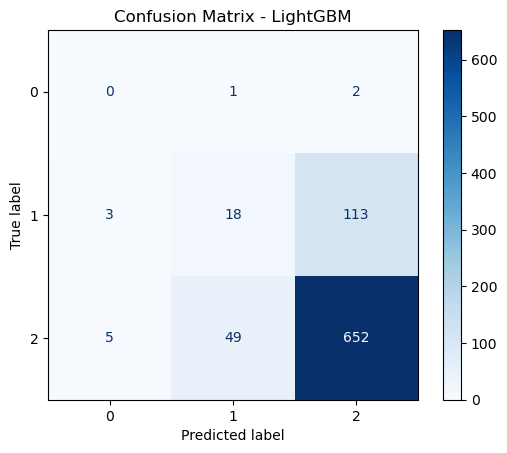

In [100]:
# Initialize the LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, min_child_samples=40, num_leaves=50, reg_alpha=0.5)

# Fit the model to the SMOTE-augmented training data
lgb_classifier.fit(X_train_smote, y_train_smote)

# Predict on the imputed testing set
lgb_predictions = lgb_classifier.predict(X_test)

# Model evaluation on the imputed testing set
print(f"Accuracy: {accuracy_score(y_test, lgb_predictions):.2f}")
print(f"Precision (Weighted): {precision_score(y_test, lgb_predictions, average='weighted'):.2f}")
print(f"Recall (Weighted): {recall_score(y_test, lgb_predictions, average='weighted'):.2f}")
print(f"F1 Score (Weighted): {f1_score(y_test, lgb_predictions, average='weighted'):.2f}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, lgb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - LightGBM')
plt.show()

## Conclusion
The comprehensive analysis involved preparing and engineering features from a dataset concerning road traffic accidents, followed by the application and evaluation of several machine learning models to predict accident severity. The models evaluated included Logistic Regression, Random Forest, Decision Tree, Gradient Boosting, XGBoost, LightGBM, and CatBoost, each chosen for its particular strengths in handling structured data, computational efficiency, and modeling accuracy.

## Key Findings
**Model Performance:** The LightGBM model outperformed others in accuracy, precision, recall, and F1 score, making it the most suitable for predicting road traffic accident severity. It achieved an accuracy of 79%, a precision (weighted) of 75%, a recall (weighted) of 79%, and an F1 Score (weighted) of 77%.

**Model Comparison:** Ensemble methods generally showed better performance compared to simpler models like Logistic Regression and Decision Tree. However, the Decision Tree model provided valuable insights due to its interpretability.

**Feature Importance:** Temporal features (like day of the week and time), environmental conditions, geospatial data, and traffic conditions were identified as significant predictors of accident severity.

## Possible Future Improvements
1. Hyperparameter Tuning: For the LightGBM model, further tuning of hyperparameters through methods such as grid search, random search, and Bayesian optimization could enhance predictive performance.
2. Cross-Validation: Implementing cross-validation techniques would help ensure that the model generalizes well to unseen data and is robust across different data splits.
3. Advanced Models Exploration: While the LightGBM model performed best among the models evaluated, there's room for exploring other advanced machine learning or deep learning models that might offer improvements in predictive accuracy or interpretability.

## Recommendation
The analysis recommends the LightGBM model for further development and deployment, given its high performance and operational efficiency. It suggests that this model offers a reliable foundation for a real-time prediction system to assist in road safety measures and decision-making.

Moving forward, the focus will be on refining this model, exploring advanced features, and enhancing its ability to predict with higher accuracy, especially for underrepresented classes in the dataset.